# Water level extraction
### A Jupyter notebook on how to detect the water level of water bodies around the world, using Sentinel-2 multi-spectral and multi-temporal imagery.

This notebook serves as an example on how to bring satellite data from space down to the hands of people living on Earth and analyze this data in order to make some conclusions which affect all of Earth's citizens. Specifically it demonstrates how to run water detection algorithm and extract surface water level for a single reservoir in a given time interval.

Hopefully this example notebook promotes an increase of awareness about environmental problems and at least a bit helps us to make the world a better place.

## Notebook outline
The outline of this notebook is the following:
1. Defining geometries of a few waterbodies
2. Preparing and executing the full workflow for water detection
   1. Downloading Sentinel-2 data (true color and NDWI index) using [SentinelHub](https://www.sentinel-hub.com/) services
   2. Cloud detection using the [s2cloudless](https://github.com/sentinel-hub/sentinel2-cloud-detector) cloud detector
   3. Water detection
3. Visualising the waterbodies and the water level over a period of time
4. Filtering out cloudy scenes to improve the results

## Requirements
- `eo-learn` (https://github.com/sentinel-hub/eo-learn)
- `Water Observatory Backend` (https://github.com/sentinel-hub/water-observatory-backend)

In order to run the example you will also need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). By default you will already have the default configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial we recommend that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your configuration yourself.

After you have prepared a configuration please put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html).

### Define the necessary imports

In [1]:
# set the autoreload and the inline plotting for matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# data manipulation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# image manipulations
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

# GIS related
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape, MultiPolygon, Polygon

# eo-learn related
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput 
from eolearn.mask import AddCloudMaskTask, AddValidDataMaskTask, get_s2_pixel_cloud_detector
from eolearn.features import SimpleFilterTask
from eolearn.geometry import VectorToRaster

# Sentinel Hub
from sentinelhub import BBox, CRS

# water observatory backend
#import sys
#sys.path.append('./water-observatory-backend/src')
#from visualisation import plot_water_body
#from geom_utils import get_bbox
#from s2_water_extraction import get_water_level_optical
#from visualisation import draw_multi, draw_poly
from utilities import *

# other
import urllib.request as request
import json
from datetime import datetime
from shapely.wkt import loads

/home/mlubej/work/work_python/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 1. Obtaining geometries of waterbodies

One example waterbody chosen in advance:
- [Theewaterskloof Dam, South Africa](https://en.wikipedia.org/wiki/Theewaterskloof_Dam)

We can easily obtain other waterbody geometries from the [BlueDot Water Observatory](https://water.blue-dot-observatory.com) API, which holds information of many waterbodies across the world. By searching for a specific waterbody, you can copy the `ID` number in the URL in order to access the nominal geometry of the corresponding waterbod (i.e. number `38538` in url `https://water.blue-dot-observatory.com/38538/2019-02-05`)

![Water Observatory screenshot](https://i.imgur.com/EqGI599.png)

In [2]:
ID = 38538

In [3]:
# function for obtaining the nominal water geometry from the water observatory API
def get_nominal_geometry(ID):
    wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{ID}/index.html'
    with request.urlopen(wb_url) as url:
        wb_data = json.loads(url.read().decode())
        nominal_outline = shape(wb_data['nominal_outline']['geometry'])
    return nominal_outline

# utility function for plotting the geometry
def plot_geometry(geom, ax = None, **kwargs):
    
    if geom is None:
        return
    if geom.exterior is None:
        return
    
    x,y = geom.exterior.xy

    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        
    ax.plot(x, y, **kwargs)

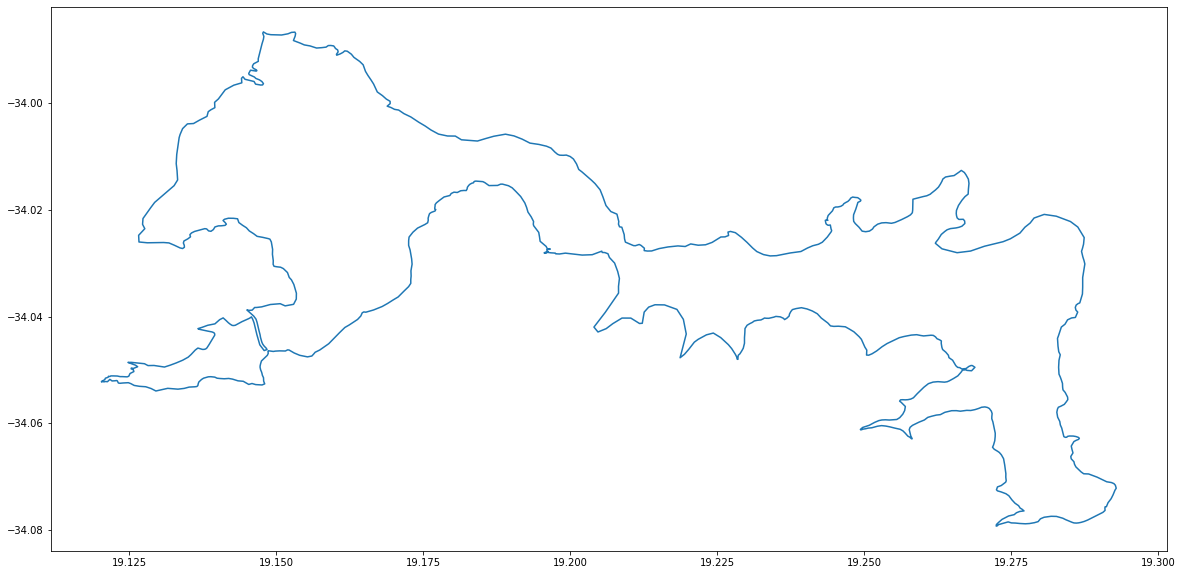

In [4]:
# get the nominal geometry
geom = get_nominal_geometry(ID)

# and plot it
plot_geometry(geom)

But now we need a bounding box for this geometry, in order to download Sentinel-2 data. We define a bounding box and inflate it a little bit in order to cosntruct a BBox object which is used with Sentinel Hub services. The BBox class also accepts the coordinate sstem (CRS), where we use the same one as in the case of the geometry, which is [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System).

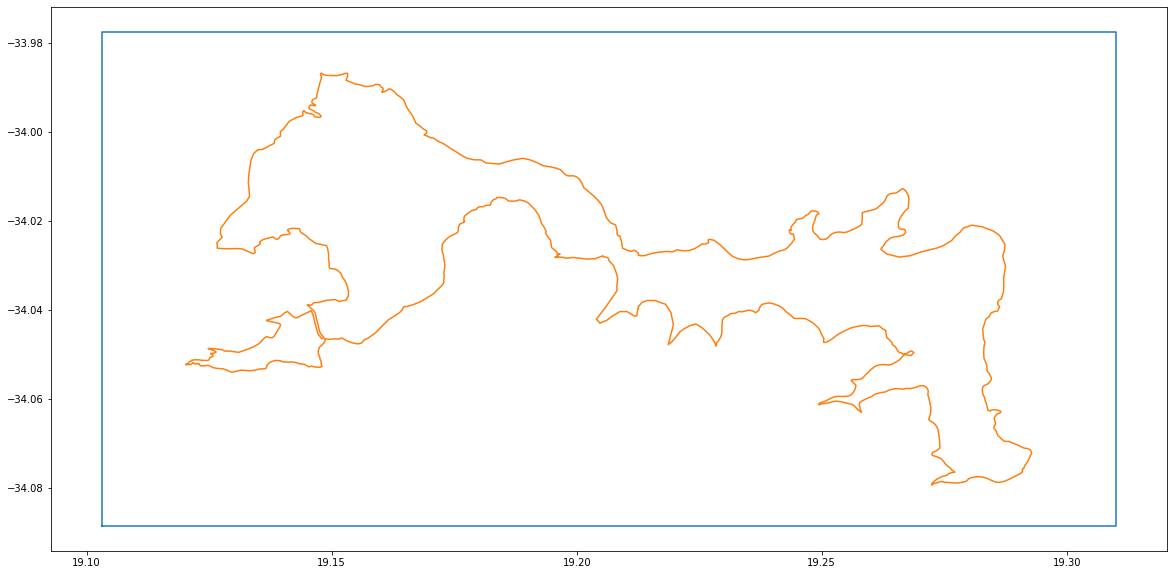

In [5]:
# create BBox instance
bbox = get_bbox(geom, inflate_bbox=0.1)

# plot the BBox and the geometry
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plot_geometry(bbox.geometry, ax)
plot_geometry(geom, ax)

# 2. Preparing and executing the full workflow for water detection

Sentinel Hub services are installed with `eo-learn`. It is an Earth observation processing framework for machine learning in Python, which provides a seamless access and processing of spatio-temporal image sequences acquired by any satellite fleet in a timely and automatic manner.

`eo-learn` works as a workflow, where a workflow consists of one or multiple tasks. Each tasks achieves a specific job (downloading data, calculating band combinations, etc) on a small patch of an area, called EOPatch. EOPatch is a container for EO and non-EO data.

Let's define a workflow to download and obtain the necessary data for water detection. We will download the RGB bands in order to actually visualise the true-color image of the waterbody. Additionally, we will download the `NDWI` band combination, which we will use for water detection. It is defined as

$$NDWI = \frac{B_3-B_8}{B_3+B_8},$$

where $B_3$ and $B_8$ are the green and near-infrared Sentinel-2 bands, respectively.

### Definitions of some custom tasks that will be used in the workflow

In [6]:
# calculate fraction of pixels with non-zero values
def coverage(array):
    return 1.0 - np.count_nonzero(array)/np.size(array)

# a function to return valid data for the area as a union of pixels with non-zero values and pixels that contain no clouds
class ValidDataPredicate:
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

# definition of a task to calculate and add the valid coverage scalar to the EOPatch
class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        
        cvrg = np.apply_along_axis(coverage, 1, np.reshape(vld, (vld.shape[0], vld.shape[1]*vld.shape[2])))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', cvrg[:,np.newaxis])
        return eopatch

# definition of a task for water mask and water level detection
class WaterDetector(EOTask):
    def execute(self, eopatch):
        
        results = [get_water_level_optical(date, eopatch.data['NDWI'][idx,...,0], geom, bbox, simplify=True) for idx, date in enumerate(eopatch.timestamp)]
        
        df = list([x['geometry'] for x in results])
        gdf = gpd.GeoDataFrame(geometry = df, crs = {'init': eopatch.bbox.crs.ogc_string()})
        gdf['TIMESTAMP'] = eopatch.timestamp
        
        eopatch.add_feature(FeatureType.VECTOR, 'WATER_OUTLINE', gdf)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', np.array([x['water_level'] for x in results])[..., np.newaxis])
        
        return eopatch

### Initializations of EOTasks

In [7]:
# TASK for downloading RGB bands
# `TRUE-COLOR-S2-L1C` is the name of the layer defined in the Sentinel Hub configurator.
# the arguments are the resolution of the image, max cloud coverage of the whole Satellite tile, and the instance ID for your Sentinel Hub account
input_task = S2L1CWCSInput(layer='TRUE-COLOR-S2-L1C', 
                           resx='20m', resy='20m', maxcc=0.5, 
                           instance_id=None)

# TASK for downloading the NDWI band combination
# other parameters are copied from the previous task
add_ndwi = S2L1CWCSInput('NDWI')

# TASK for cloud detection
# cloud probability map (CLP) and cloud mask (CLM) are calculated at 160 m resolution in order to speed up the process
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=None)

# TASK for adding a raster mask of the nominal water extent (NOMINAL_WATER) 
# raster shape is provided by an existing feature inside of the EOPatch
gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'}, geometry=[geom])
add_nominal_water = VectorToRaster(raster_feature=(FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), 
                                   vector_input=gdf, values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), 
                                   raster_dtype=np.uint8)

# TASK for adding valid data mask to the EOPatch (mask type)
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

# TASK for adding valid data coverage to the EOPatch (scalar type)
add_coverage = AddValidDataCoverage()

# TASK for water detection
water_det = WaterDetector()

### Define and run the workflow

In [8]:
# initialize the workflow
workflow = LinearWorkflow(input_task, 
                          add_ndwi, 
                          cloud_det, 
                          add_nominal_water, 
                          add_valmask, 
                          add_coverage,
                          water_det
                         )

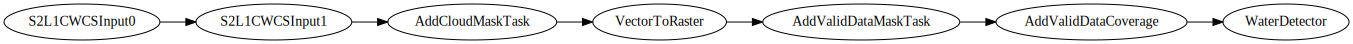

In [9]:
workflow.dependency_graph()

In [10]:
%%time

# time interval definition
time_interval = ['2017-01-01','2019-1-1']

# execute the workflow
result = workflow.execute({
    input_task: {
        'bbox': bbox,
        'time_interval': time_interval
    },
})

CPU times: user 3min 8s, sys: 9.43 s, total: 3min 18s
Wall time: 2min 47s


### Structure of the `EOPatch`

In [11]:
# result is in the form of a dictionary
eopatch = result.eopatch()
eopatch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(97, 618, 954, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(97, 618, 954, 1), dtype=float32)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(97, 618, 954, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(97, 618, 954, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(97, 618, 954, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(97, 618, 954, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(97, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(97, 1), dtype=float64)
  }
  label: {}
  vector: {
    WATER_OUTLINE: geopandas.GeoDataFrame(columns=['geometry', 'TIMESTAMP'], length=97, crs=EPSG:4326)
  }
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(618, 954, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedel

Let's now visualise the first few true-color images of the selected waterbody in the given time series. We see below that some images contain clouds, which causes problems in proper water level detection.

### Plot the NDWI to see how the water detector traces the waterbody outline

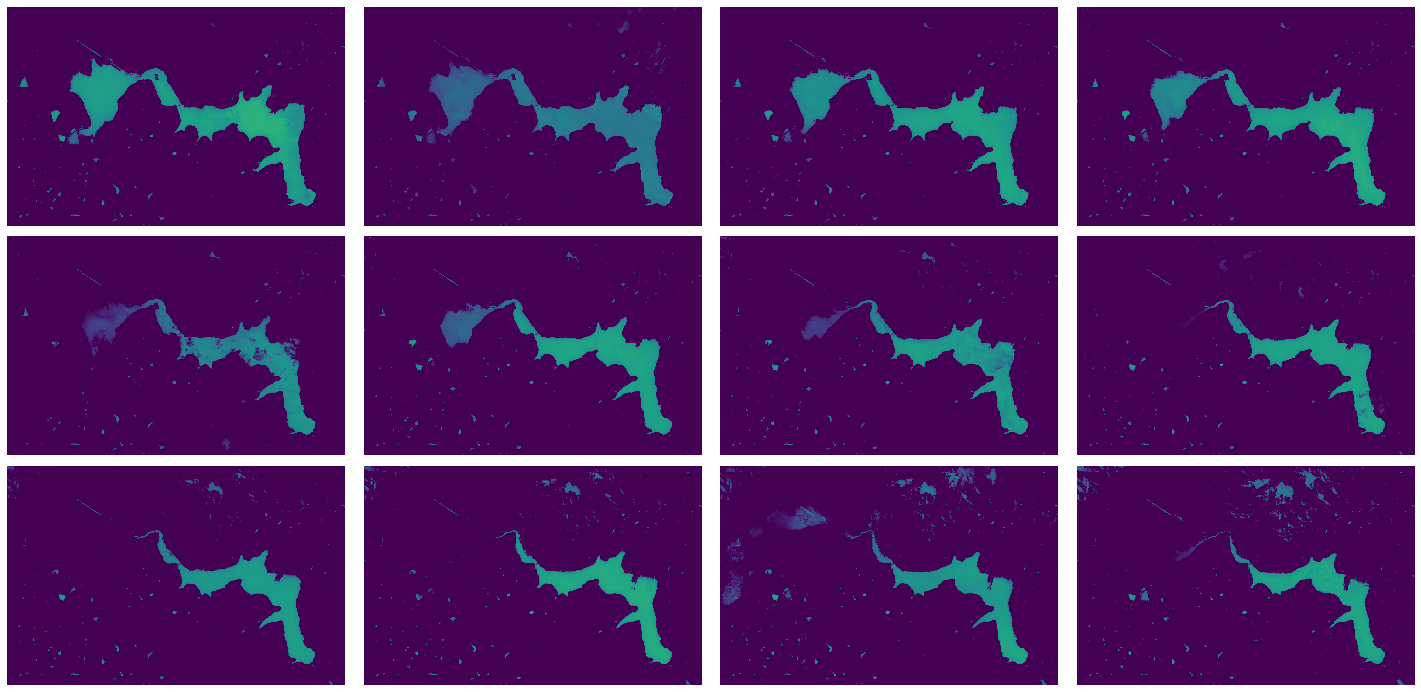

In [12]:
# get aspect ratio of image for better plotting
image_ar = eopatch.mask_timeless['NOMINAL_WATER'].shape[0] / eopatch.mask_timeless['NOMINAL_WATER'].shape[1]

# plot the NDWI at different dates
fig = plt.figure(figsize=(20,15*image_ar))

for i in range(12):
    ax = plt.subplot(3,4,i+1)
    ax.imshow(eopatch.data['NDWI'][i].squeeze(), vmin = 0, vmax = 1)
    ax.axis('off')
    
plt.tight_layout()

### Plot true-color images with the detected water outlines

In [13]:
def plot_waterbody(img, date, dam_poly, dam_bbox, water_extent, water_level, 
                    color_nominal='white', color_current='xkcd:lime', ax = None):

    shape = img.shape[0:2]
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
    ax.imshow(img,extent=[dam_bbox.min_x,dam_bbox.max_x,dam_bbox.min_y,dam_bbox.max_y])
        
    if isinstance(dam_poly, Polygon):
        draw_poly(ax,dam_poly, color=color_nominal)
    elif isinstance(dam_poly, MultiPolygon):
        draw_multi(ax,dam_poly, color=color_nominal)
        
    if isinstance(water_extent, Polygon):
        draw_poly(ax,water_extent, color=color_current)
    elif isinstance(water_extent, MultiPolygon):
        draw_multi(ax, water_extent, color=color_current)

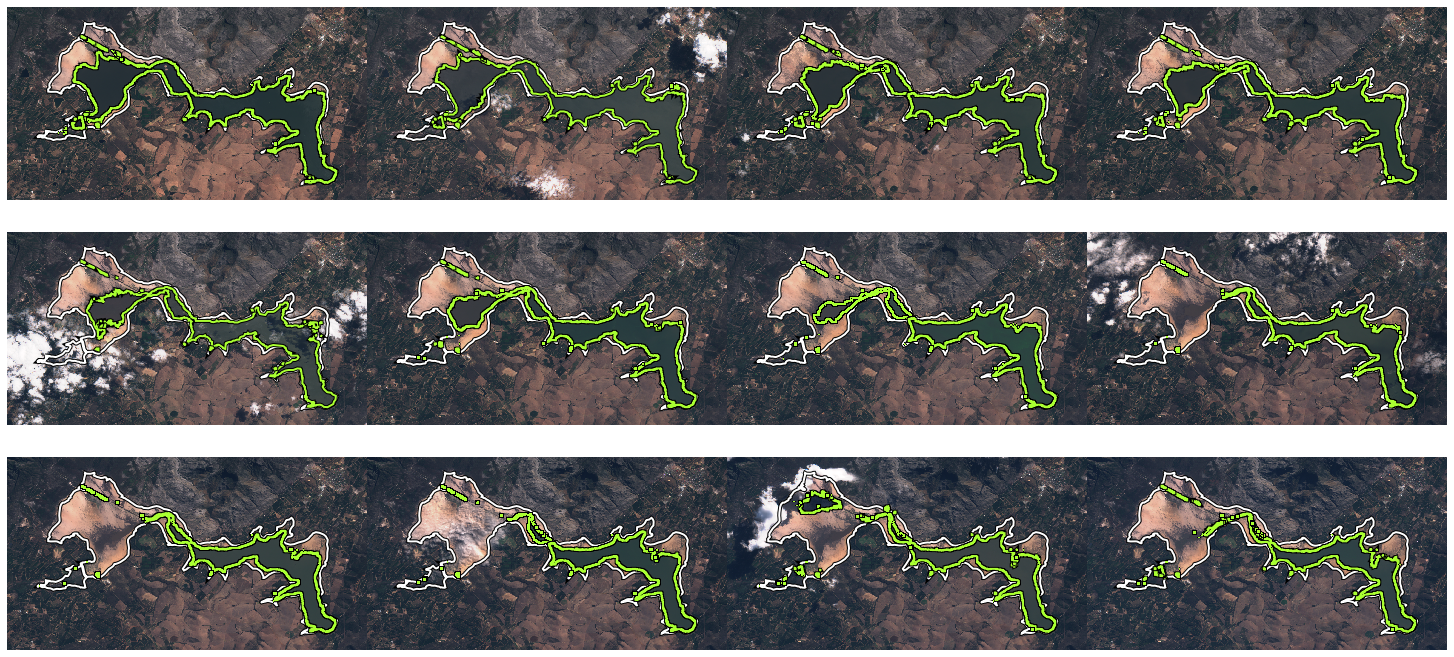

In [14]:
# get aspect ratio of image for better plotting
image_ar = eopatch.data['TRUE-COLOR-S2-L1C'][0].shape[0] / eopatch.data['TRUE-COLOR-S2-L1C'][0].shape[1]

fig = plt.figure(figsize=(20,15*image_ar))

for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plot_waterbody(eopatch.data['TRUE-COLOR-S2-L1C'][i], eopatch.timestamp[i], geom, bbox, eopatch.vector['WATER_OUTLINE']['geometry'][i], eopatch.scalar['WATER_LEVEL'][i], ax=ax)
    ax.axis('off')
    
plt.tight_layout(pad=0)

### Plotting the detected water levels

/home/mlubej/work/work_python/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


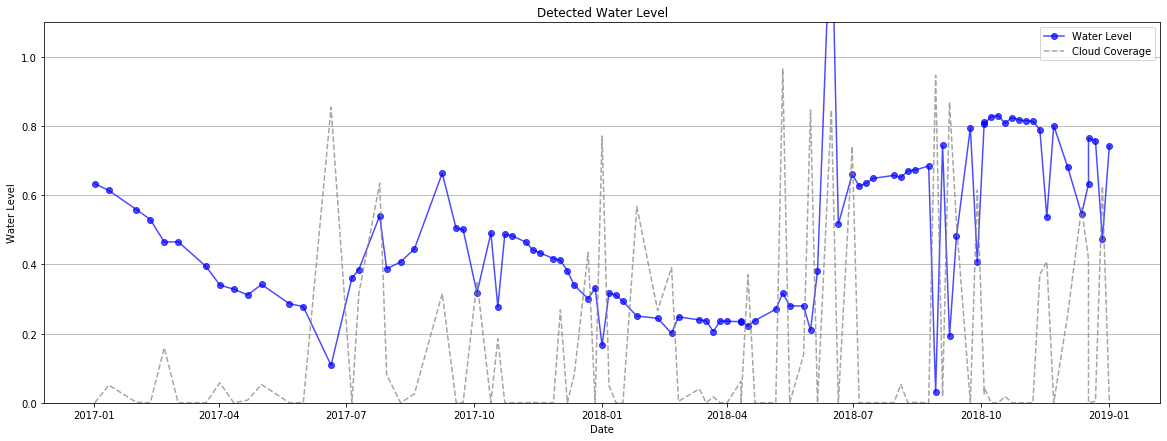

In [15]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

# plot the water level with no cloudy scene filtering (accept all clouds)
ax = plot_water_levels(eopatch, 1.0);

We see a lot of fluctuations in the water level. At the same time, cloud coverage is plotted, and it shares the same dates as the water level outliers.

Let us now set a threshold for tha maximum cloud coverage of 2 % and filter out the dates which correspond to cloudy scenes. This is done by filtering out the dates which have a value of `eopatch.scalar['COVERAGE']` larger than 0.02.

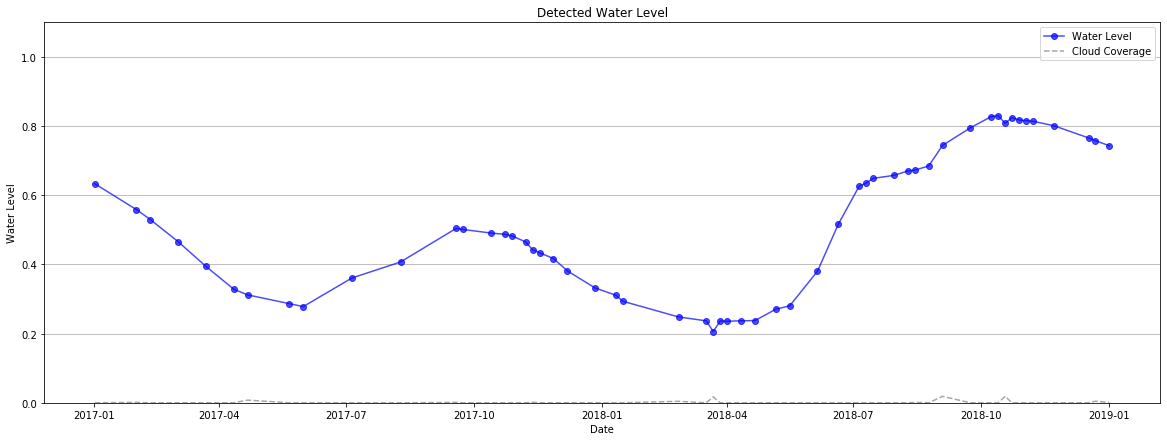

In [16]:
plot_water_levels(eopatch, 0.02);